In [1]:
!wget http://files.grouplens.org/datasets/movielens/ml-1m.zip

--2021-08-29 17:40:05--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  20.5KB/s    in 4m 41s  

2021-08-29 17:44:46 (20.6 KB/s) - ‘ml-1m.zip’ saved [5917549/5917549]



In [2]:
!unzip ml-1m.zip

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [3]:
import pandas as pd

In [6]:
movies_df = pd.read_csv("ml-1m/movies.dat", sep='::',
                    names=['movieId', 'title', 'genres'],
                    encoding='latin-1', engine='python')

In [7]:
movies_df['movieId_index'] = movies_df['movieId'].astype('category').cat.codes # pandas 오브젝트를 category 타입으로 캐스팅한다.

In [8]:
movies_df.head(4)

,movieId,title,genres,movieId_index
0,1,Toy Story (1995),Animation|Children's|Comedy,0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1
2,3,Grumpier Old Men (1995),Comedy|Romance,2
3,4,Waiting to Exhale (1995),Comedy|Drama,3


In [10]:
users_df = pd.read_csv('ml-1m/users.dat', sep='::', 
                    header=None, 
                    names=['userId', 'gender', 'age', 'occupation', 'zipcode'],
                    engine='python')

In [17]:
users_df['gender_index'] = users_df['gender'].astype('category').cat.codes
users_df['age_index'] = users_df['age'].astype('category').cat.codes 
users_df['occupation_index'] = users_df['occupation'].astype('category').cat.codes
users_df['userId_index'] = users_df['userId'].astype('category').cat.codes

In [13]:
users_df.head(4)

,userId,gender,age,occupation,zipcode,gender_index,age_index,occupation_index,userId_index
0,1,F,1,10,48067,0,0,10,0
1,2,M,56,16,70072,1,6,16,1
2,3,M,25,15,55117,1,2,15,2
3,4,M,45,7,02460,1,4,7,3


In [18]:
ratings = pd.read_csv('ml-1m/ratings.dat', sep='::',
                    names=['userId', 'movieId', 'rating', 'time'],
                    engine='python')

In [19]:
ratings = ratings.join(movies_df.set_index('movieId'), on = 'movieId')
ratings = ratings.join(users_df.set_index('userId'), on='userId')

In [20]:
ratings.head(4)

,userId,movieId,rating,time,title,genres,movieId_index,gender,age,occupation,zipcode,gender_index,age_index,occupation_index,userId_index
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,1176,F,1,10,48067,0,0,10,0
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical,655,F,1,10,48067,0,0,10,0
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance,902,F,1,10,48067,0,0,10,0
3,1,3408,4,978300275,Erin Brockovich (2000),Drama,3339,F,1,10,48067,0,0,10,0


In [21]:
features_columns = ['userId_index', 'movieId_index', 'age_index', 'gender_index', 'occupation_index']

In [23]:
features_sizes = {
    'userId_index' : len(ratings['userId_index'].unique()),
    'movieId_index' : len(ratings['movieId_index'].unique()),
    'age_index' : len(ratings['age_index'].unique()),
    'gender_index' : len(ratings['gender_index'].unique()),
    'occupation_index' : len(ratings['occupation_index'].unique()),
}

In [24]:
features_sizes

{'userId_index': 6040,
 'movieId_index': 3706,
 'age_index': 7,
 'gender_index': 2,
 'occupation_index': 21}

In [25]:
next_offsets = 0 
features_offsets = {} 
for k, v in features_sizes.items():
    features_offsets[k] = next_offsets
    next_offsets += v 

In [26]:
for column in features_columns:
    ratings[column] = ratings[column].apply(lambda c: c + features_offsets[column])

In [28]:
ratings[[*features_columns, 'rating']].head(4)

,userId_index,movieId_index,age_index,gender_index,occupation_index,rating
0,0,7216,9746,9753,9765,5
1,0,6695,9746,9753,9765,3
2,0,6942,9746,9753,9765,3
3,0,9379,9746,9753,9765,4


In [50]:
import time 
import math

import torch 
import torch.utils.data as data 
import torch.nn as nn 
import torch.optim as optim 
import numpy as np 

In [33]:
data_x = torch.tensor(ratings[features_columns].values)
data_y = torch.tensor(ratings['rating'].values).float()
dataset = data.TensorDataset(data_x, data_y)

In [34]:
batch_size = 1024 
train_n = int(len(dataset) * 0.9)
valid_n = len(dataset) - train_n 
splits = [train_n, valid_n]
assert sum(splits) == len(dataset)
trainset, devset = torch.utils.data.random_split(dataset, splits)
train_dataloader = data.DataLoader(trainset, batch_size=batch_size, shuffle=True) 
dev_dataloader = data.DataLoader(devset, batch_size=batch_size, shuffle=True)

In [35]:
def trunc_normal_(x, mean=0., std=1.):
    return x.normal_().fmod_(2).mul_(std).add_(mean)

In [37]:
class FMModel(nn.Module):
    def __init__(self, n, k):
        super().__init__()

        self.w0 = nn.Parameter(torch.zeros(1))
        self.bias = nn.Embedding(n, 1)
        self.embeddings = nn.Embedding(n, k)

        with torch.no_grad(): trunc_normal_(self.embeddings.weight, std=0.01)
        with torch.no_grad(): trunc_normal_(self.bias.weight, std=0.01)

    def forward(self, X):
        emb = self.embeddings(X)

        power_of_sum = emb.sum(dim=1).pow(2)
        sum_of_pow = emb.pow(2).sum(dim=1)

        pairwise = (power_of_sum - sum_of_pow).sum(1)*0.5
        bias = self.bias(X).squeeze().sum(1)

        return torch.sigmoid(self.w0 + bias + pairwise) * 5.5 

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def fit(iterator, model, optimizer, criterion):
    train_loss = 0 
    model.train()

    for x, y in iterator:
        optimizer.zero_grad()
        y_hat = model(x.to(device))
        loss = criterion(y_hat, y.to(device))
        train_loss = loss.item() * x.shape[0]
        loss.backward()
        optimizer.step()
    return train_loss / len(iterator.dataset) 

def test(iterator, model, criterion):
    train_loss = 0 
    model.eval() 

    for x, y in iterator:
        with torch.no_grad():
            y_hat = model(x.to(device))
        loss = criterion(y_hat, y.to(device))
        train_loss = loss.item() * x.shape[0]
    return train_loss / len(iterator.dataset)

In [45]:
def train_n_epochs(model, n, optimizer, scheduler):
    criterion = nn.MSELoss().to(device)
    for epoch in range(n):
        start_time = time.time()
        train_loss = fit(train_dataloader, model, optimizer, criterion)
        valid_loss = test(dev_dataloader, model, criterion) 
        scheduler.step()
        secs = int(time.time() - start_time)

        print(f"epoch {epoch}. time: {secs}[s]")
        print(f"\ttrain rmse: {(math.sqrt(train_loss)):.4f}")
        print(f"\tvalidation rms: {(math.sqrt(valid_loss)):.4f}")

In [47]:
model = FMModel(data_x.max() + 1, 120).to(device)

wd = 1e-5 
lr = 1e-3
epochs = 10
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[7], gamma=0.1)
criterion = nn.MSELoss().to(device) 

for epoch in range(epochs):
    start_time = time.time( )
    train_loss = fit(train_dataloader, model, optimizer, criterion)
    valid_loss = test(dev_dataloader, model, criterion)
    scheduler.step() 
    secs = int(time.time() - start_time)

    print(f"epoch {epoch}. time: {secs}[s]")
    print(f"\ttrain rmse: {math.sqrt(train_loss):.4f}")
    print(f"\tvalidation rmse: {math.sqrt(valid_loss):.4f}")

epoch 0. time: 33[s]
	train rmse: 0.0093
	validation rmse: 0.0757
epoch 1. time: 33[s]
	train rmse: 0.0087
	validation rmse: 0.0720
epoch 2. time: 32[s]
	train rmse: 0.0093
	validation rmse: 0.0745
epoch 3. time: 32[s]
	train rmse: 0.0076
	validation rmse: 0.0746
epoch 4. time: 32[s]
	train rmse: 0.0088
	validation rmse: 0.0690
epoch 5. time: 30[s]
	train rmse: 0.0073
	validation rmse: 0.0676
epoch 6. time: 32[s]
	train rmse: 0.0079
	validation rmse: 0.0684
epoch 7. time: 31[s]
	train rmse: 0.0073
	validation rmse: 0.0718
epoch 8. time: 31[s]
	train rmse: 0.0078
	validation rmse: 0.0727
epoch 9. time: 31[s]
	train rmse: 0.0069
	validation rmse: 0.0718


In [48]:
movies = ratings.drop_duplicates('movieId_index').copy()
movie_embeddings = model.embeddings(torch.tensor(movies['movieId_index'].values, device=device).long())
movies['embedding'] = movie_embeddings.tolist()
movie_biases = model.bias(torch.tensor(movies['movieId_index'].values, device=device).long())
movies['bias'] = movie_biases.cpu().detach().numpy()

In [49]:
movies[['title', 'movieId_index', 'embedding', 'bias']]

,title,movieId_index,embedding,bias
0,One Flew Over the Cuckoo's Nest (1975),7216,"[-0.2293398380279541, 0.01329464465379715, 0.1...",0.278234
1,James and the Giant Peach (1996),6695,"[-0.17184315621852875, 0.008792947046458721, 0...",-0.034111
2,My Fair Lady (1964),6942,"[0.13778415322303772, 0.035215508192777634, 0....",0.120326
3,Erin Brockovich (2000),9379,"[0.07152204215526581, 0.08016274124383926, 0.0...",0.180796
4,"Bug's Life, A (1998)",8326,"[0.15271271765232086, 0.04877089336514473, 0.0...",0.145772
...,...,...,...,...
919876,Modulations (1998),8169,"[-0.010986817069351673, 0.034929100424051285, ...",0.086558
940262,Broken Vessels (1998),8674,"[0.0004596385988406837, 0.0009937833528965712,...",-0.067447
957826,White Boys (1999),8816,"[0.048646632581949234, 0.014861658215522766, 0...",-0.131593
970914,One Little Indian (1973),9578,"[0.013227395713329315, 0.014315467327833176, 0...",0.092184


In [58]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 
import seaborn as sns

movies_subset = movies[movies['genres'].str.contains('Children\'s|Horror|Documentary')].copy()
X = np.stack(movies_subset['embedding'].values)
ldr = TSNE(n_components=2, random_state=0)
Y = ldr.fit_transform(X)
movies_subset['x'] = Y[:, 0]
movies_subset['y'] = Y[:, 1]

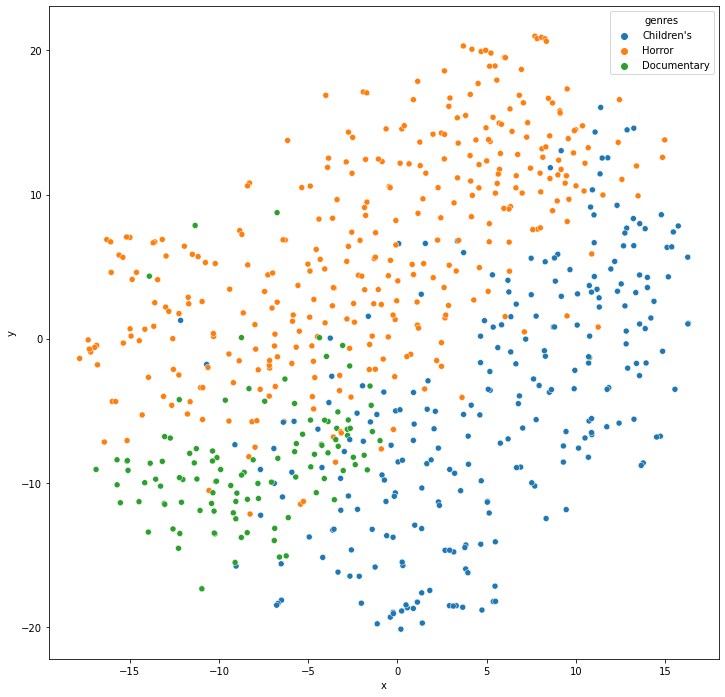

In [59]:
def single_genre(g):
    for i in ['Children\'s', 'Horror', 'Documentary']:
        if i in g: return i
        
movies_subset['genres']=movies_subset['genres'].apply(single_genre)
plt.figure(figsize=(12, 12))
ax = sns.scatterplot(x="x", y="y", hue='genres',data=movies_subset)
plt.savefig('movie_emb.png', bbox_inches='tight')

In [61]:
import torch.functional as F 

star_wars_5_index = torch.tensor(6297, device=device)
star_war_embeddings = model.embeddings(star_wars_5_index)
cosine_similiarities = torch.tensor([F.cosine_similarity(star_war_embeddings, i, dim=0) for i in movie_embeddings])
movies.iloc[cosine_similiarities.argsort(descending=True).detach().numpy()]['title'].values[:10]

array(['Star Wars: Episode IV - A New Hope (1977)',
       'Star Wars: Episode V - The Empire Strikes Back (1980)',
       'Star Wars: Episode VI - Return of the Jedi (1983)',
       'Raiders of the Lost Ark (1981)',
       'Indiana Jones and the Last Crusade (1989)', 'Ghostbusters (1984)',
       'Star Wars: Episode I - The Phantom Menace (1999)',
       'Batman (1989)', 'Princess Bride, The (1987)',
       'Back to the Future (1985)'], dtype=object)

In [62]:
man_embedding = model.embeddings(torch.tensor(9754, device=device))
age18_25_embedding = model.embeddings(torch.tensor(9747, device=device))
meta_embedding = man_embedding + age18_25_embedding
rankings = movie_biases.squeeze() + (meta_embedding*movie_embeddings).sum(1)
[i for i in movies.iloc[rankings.argsort(descending=True).cpu()]['title'].values][:10]

['Shawshank Redemption, The (1994)',
 'Usual Suspects, The (1995)',
 'American Beauty (1999)',
 'Godfather, The (1972)',
 'Life Is Beautiful (La Vita è bella) (1997)',
 'Braveheart (1995)',
 'Monty Python and the Holy Grail (1974)',
 'Sanjuro (1962)',
 'Star Wars: Episode V - The Empire Strikes Back (1980)',
 'GoodFellas (1990)']

In [64]:
from elasticsearch import Elasticsearch, helpers

In [65]:
es = Elasticsearch()

In [177]:
recsys_mapping = {
  "mappings": {
    "properties": {
      "feature_type":{
        "type":"keyword"
      },
      "embedding": {
        "type": "dense_vector",
        "dims": 120
      },
      "bias": {
        "type":"double"
      },
      "title" : {
        "type" : "keyword"
      }
    }
  }
}


try:
    es.indices.delete(index='recsys')
except Exception as e:
    print(e)
finally:
    try:
      es.indices.create(index='recsys', body=recsys_mapping)
    except:
      print(e)
    finally:
      pprint(es.indices.get(index='recsys'))

/Users/seokwoo/opt/anaconda3/envs/bert/lib/python3.7/site-packages/elasticsearch/connection/base.py:208: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.13/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


{'recsys': {'aliases': {},
            'mappings': {'properties': {'bias': {'type': 'double'},
                                        'embedding': {'dims': 120,
                                                      'type': 'dense_vector'},
                                        'feature_type': {'type': 'keyword'},
                                        'title': {'type': 'keyword'}}},
            'settings': {'index': {'creation_date': '1630244604291',
                                   'number_of_replicas': '1',
                                   'number_of_shards': '1',
                                   'provided_name': 'recsys',
                                   'routing': {'allocation': {'include': {'_tier_preference': 'data_content'}}},
                                   'uuid': 'XBXxslnEQxehMbVEj4WWsw',
                                   'version': {'created': '7130099'}}}}}


In [178]:
def generate_movie_docs():
    for i, movie in movies.iterrows():
        movie['embedding'] = [abs(v) for v in movie['embedding']]
        yield {
            '_index' : 'recsys',
            '_id' : f'movie_{movie["movieId"]}',
            '_source' : {'embedding' : movie['embedding'],
                        'bias' : movie['bias'],
                        'feature_type' : 'movie',
                        'title' : movie['title']
                        }
        }

In [179]:
helpers.bulk(es, generate_movie_docs())

/Users/seokwoo/opt/anaconda3/envs/bert/lib/python3.7/site-packages/elasticsearch/connection/base.py:208: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.13/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


(3706, [])

In [180]:
users = ratings.drop_duplicates('userId_index').copy()
users['embedding'] = model.embeddings(torch.tensor(users['userId_index'].values, device=device)).tolist()
users['bias'] = model.bias(torch.tensor(users['userId_index'].values, device=device)).detach().numpy()

In [181]:
def generate_user_docs():
    for i, user in users.iterrows():
        yield {
            '_index' : 'recsys',
            '_id' : f'user_{user["userId"]}',
            '_source' : {'embedding' : user['embedding'],
                        'bias': user['bias'],
                        'feature_type' : 'user',
                        }
        }

In [182]:
helpers.bulk(es, generate_user_docs())

(6040, [])

In [183]:
ages = [i+features_offsets['age_index'] for i in range(features_sizes['age_index'])]

In [184]:
def generate_age_docs():
    for age_index in ages:
        yield {
            '_index' : 'recsys',
            '_id' : f'age_{age_index}',
            '_source' : {'embedding' : model.embeddings(torch.tensor(age_index, device=device)).tolist(),
                        'bias' : model.bias(torch.tensor(age_index, device=device)).item(),
                        'feature_type' : 'age'
                        }
        }

In [185]:
helpers.bulk(es, generate_age_docs())

(7, [])

In [186]:
genders = [i+features_offsets['gender_index'] for i in range(features_sizes['gender_index'])]

In [187]:
def generate_gender_docs():
    for gender_index in genders:
        yield {
            '_index' : 'recsys',
            '_id' : f'gender_{gender_index}',
            '_source' : {'embedding' : model.embeddings(torch.tensor(gender_index, device=device)).tolist(),
                        'bias' : model.bias(torch.tensor(gender_index, device=device)).item(),
                        'feature_type' : 'gender',
            }
        }

In [188]:
helpers.bulk(es, generate_gender_docs())

(2, [])

In [189]:
occupations = [i + features_offsets['occupation_index'] for i in range(features_sizes['occupation_index'])]

In [190]:
def generate_occupation_docs():
    for occupation_index in occupations:
        yield {
            '_index' : 'recsys',
            '_id' : f'occupation_{occupation_index}',
            '_source' : {'embedding' : model.embeddings(torch.tensor(occupation_index, device=device)).tolist(),
                        'bias' : model.bias(torch.tensor(occupation_index, device=device)).item(),
                        'feature_type' : 'occupation',
                        }
        }

In [191]:
helpers.bulk(es, generate_occupation_docs())

(21, [])

In [192]:
pprint(es.indices.get(index='recsys'))

{'recsys': {'aliases': {},
            'mappings': {'properties': {'bias': {'type': 'double'},
                                        'embedding': {'dims': 120,
                                                      'type': 'dense_vector'},
                                        'feature_type': {'type': 'keyword'},
                                        'title': {'type': 'keyword'}}},
            'settings': {'index': {'creation_date': '1630244604291',
                                   'number_of_replicas': '1',
                                   'number_of_shards': '1',
                                   'provided_name': 'recsys',
                                   'routing': {'allocation': {'include': {'_tier_preference': 'data_content'}}},
                                   'uuid': 'XBXxslnEQxehMbVEj4WWsw',
                                   'version': {'created': '7130099'}}}}}


In [193]:
metadata = es.mget({"docs" : [
    {
        "_index" : "recsys",
        "_id" : "age_9747"
    },
    {
        "_index" : "recsys",
        "_id" : "gender_9754"
    }
]})

In [194]:
from pprint import pprint 

pprint(metadata)

{'docs': [{'_id': 'age_9747',
           '_index': 'recsys',
           '_primary_term': 1,
           '_seq_no': 9747,
           '_source': {'bias': 0.04977013170719147,
                       'embedding': [-0.017717693001031876,
                                     -0.015451682731509209,
                                     0.02026461809873581,
                                     0.059114061295986176,
                                     0.031505413353443146,
                                     -0.04306042566895485,
                                     0.01051869336515665,
                                     -0.01670573465526104,
                                     0.025431832298636436,
                                     -0.014832258224487305,
                                     0.052585914731025696,
                                     0.005719239357858896,
                                     0.02500726655125618,
                                     -0.1374354511499405,
   

In [195]:
embeddings = [doc['_source']['embedding'] for doc in metadata['docs']]

In [196]:
v_metadata = [ abs(sum(pair)) for pair in zip(*embeddings)]
print(len(v_metadata))

120


In [207]:
search_body = {
    "query": {
    "script_score": {
      "query" : {
          "bool" : {
          "filter" : {
            "term" : {
              "feature_type" : "movie" 
            }
          }
        }
      },
      "script": {
        "source": "cosineSimilarity(params.query_vector, 'embedding') + doc['bias'].value", 
        # "source": "dotProduct(params.query_vector, 'embedding') + doc['bias'].value", 
        # "source": "cosineSimilarity(params.query_vector, 'embedding') + 1.0", 
        "params": {
          "query_vector": v_metadata
        }
      }
    }
  }
}
[hit['_source']['title'] for hit in es.search(search_body,index='recsys',_source_includes='title')['hits']['hits']]

/Users/seokwoo/opt/anaconda3/envs/bert/lib/python3.7/site-packages/elasticsearch/connection/base.py:208: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.13/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


['Bloody Child, The (1996)',
 'Hungarian Fairy Tale, A (1987)',
 'Windows (1980)',
 'Bye-Bye (1995)',
 'Daens (1992)',
 "Another Man's Poison (1952)",
 'Chain of Fools (2000)',
 'Time of the Gypsies (Dom za vesanje) (1989)',
 'Sanjuro (1962)',
 'Firelight (1997)']